In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer

import category_encoders as ce

In [2]:
df = pd.read_csv('../data/df_clean_nulls2.csv', index_col=0).drop(columns='city')
df.head()

,enrollee_id,city_development_index,gender,relevent_experience,enrolled_university,education_level,major,company_size,company_type,last_new_job,training_hours,target,exp_range,city_group
0,8949,0.920,Male,1,no_enrollment,Graduate,STEM,NaN,NaN,1,36,1.0,>20,city_103
1,29725,0.776,Male,0,no_enrollment,Graduate,STEM,50-99,private_limited,>4,47,0.0,11-15,city_other
2,11561,0.624,NaN,0,full_time,Graduate,STEM,NaN,NaN,never,83,0.0,2-5,city_21
3,33241,0.789,NaN,0,NaN,Graduate,Business Degree,NaN,private_limited,never,52,1.0,<=1,city_other
4,666,0.767,Male,1,no_enrollment,Masters,STEM,50-99,startup_funded,4,8,0.0,>20,city_other


In [3]:
df.shape

(21037, 14)

# I. Separate Train and Test Sets

First, I'll separate the pre-defined train and test sets. This test set does not include the target feature, and therefore cannot be used for training or validation.

In [4]:
main_df = df.loc[df['target'].notna()]
final_eval_df = df.loc[df['target'].isna()]

main_df.shape, final_eval_df.shape

((18908, 14), (2129, 14))

The train_df will now be split into its own train/test set for encoding/imputing.

In [5]:
# Split into test/train

train, test = train_test_split(main_df, random_state=0)
train.shape, test.shape

((14181, 14), (4727, 14))

# I. Encoding Categorical Columns

In [6]:
train.dtypes[train.dtypes=='object']

gender                 object
enrolled_university    object
education_level        object
major                  object
company_size           object
company_type           object
last_new_job           object
exp_range              object
city_group             object
dtype: object

### a) Ordinal Columns

In [7]:
ord_cols = ['education_level', 'company_size', 'last_new_job', 'exp_range']

In [8]:
train['education_level'].value_counts()

Graduate          8731
Masters           3267
High School       1458
Phd                297
Primary School     228
Name: education_level, dtype: int64

In [9]:
ord_map = [
    {'col': 'education_level',
    'mapping': {'Primary School':0, 'High School':1, 'Graduate':2, 'Masters':3, 'Phd':4}},
    {'col': 'company_size',
     'mapping': {'<10': 0, '10-49': 1, '50-99': 2, '100-499':3, '500-999':4, '1000-4999':5, '5000-9999':6, '10000+':7}},
    {'col': 'last_new_job',
     'mapping': {'never': 0, '1': 1, '2': 2, '3':3, '4':4, '>4':5}},
    {'col': 'exp_range', 
     'mapping': {'<=1':0, '2-5':1, '6-10':2, '11-15':3, '16-20':4,'>20':5}}
]

In [10]:
ord_encoder = ce.OrdinalEncoder(
    cols=ord_cols, mapping=ord_map, return_df=True,
    handle_unknown='return_nan', handle_missing='return_nan'
)

ord_encoder.fit(train)

train = ord_encoder.transform(train)
test = ord_encoder.transform(test)
final_eval_df = ord_encoder.transform(final_eval_df)

In [11]:
train.shape, test.shape, final_eval_df.shape

((14181, 14), (4727, 14), (2129, 14))

In [12]:
# Original df

main_df[ord_cols].loc[[2913, 13038, 13226, 10167, 16867]]

,education_level,company_size,last_new_job,exp_range
2913,Masters,10-49,1,2-5
13038,Masters,10000+,2,6-10
13226,Graduate,10-49,1,2-5
10167,Primary School,NaN,never,<=1
16867,Graduate,50-99,4,>20


In [13]:
# Encoded df

train[ord_cols].head()

,education_level,company_size,last_new_job,exp_range
2913,3.0,1.0,1.0,1.0
13038,3.0,7.0,2.0,2.0
13226,2.0,1.0,1.0,1.0
10167,0.0,NaN,0.0,0.0
16867,2.0,2.0,4.0,5.0


In [14]:
train[ord_cols].dtypes

education_level    float64
company_size       float64
last_new_job       float64
exp_range          float64
dtype: object

Looks good. After imputing missing values, these columns will be converted to int.

### b) One-Hot Encode Columns

In [15]:
cat_cols = ['gender', 'city_group', 'enrolled_university', 'major', 'company_type']

In [16]:
oh_encoder = ce.OneHotEncoder(cols=cat_cols, return_df=True, use_cat_names=True,
                           handle_unknown='return_nan', handle_missing='return_nan')

oh_encoder.fit(train)

train = oh_encoder.transform(train)
test = oh_encoder.transform(test)
final_eval_df = oh_encoder.transform(final_eval_df)

In [17]:
train.shape, test.shape, final_eval_df.shape

((14181, 37), (4727, 37), (2129, 37))

In [18]:
# Create new list of cat_cols

cat_cols2 = []
for i in cat_cols:
    for col_name in train.columns:
        if i in col_name:
            cat_cols2.append(col_name)
cat_cols2

['gender_nan',
 'gender_Male',
 'gender_Female',
 'gender_Other',
 'city_group_city_114',
 'city_group_city_21',
 'city_group_city_other',
 'city_group_city_103',
 'city_group_city_16',
 'city_group_nan',
 'enrolled_university_no_enrollment',
 'enrolled_university_full_time',
 'enrolled_university_part_time',
 'enrolled_university_nan',
 'major_STEM',
 'major_Other',
 'major_nan',
 'major_Humanities',
 'major_Arts',
 'major_No Major',
 'major_Business Degree',
 'company_type_private_limited',
 'company_type_startup_earlystage',
 'company_type_nan',
 'company_type_public_sector',
 'company_type_startup_funded',
 'company_type_NGO',
 'company_type_Other']

In [19]:
# Original df

main_df[cat_cols].head()

,gender,city_group,enrolled_university,major,company_type
0,Male,city_103,no_enrollment,STEM,NaN
1,Male,city_other,no_enrollment,STEM,private_limited
2,NaN,city_21,full_time,STEM,NaN
3,NaN,city_other,NaN,Business Degree,private_limited
4,Male,city_other,no_enrollment,STEM,startup_funded


In [20]:
# After encoding

train[cat_cols2].head()

,gender_nan,gender_Male,gender_Female,gender_Other,city_group_city_114,city_group_city_21,city_group_city_other,city_group_city_103,city_group_city_16,city_group_nan,...,major_Arts,major_No Major,major_Business Degree,company_type_private_limited,company_type_startup_earlystage,company_type_nan,company_type_public_sector,company_type_startup_funded,company_type_NGO,company_type_Other
2913,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
13038,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
13226,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10167,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16867,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### c) Ensure all column dtypes are correct

In [21]:
train.dtypes

enrollee_id                            int64
city_development_index               float64
gender_nan                           float64
gender_Male                          float64
gender_Female                        float64
gender_Other                         float64
relevent_experience                    int64
enrolled_university_no_enrollment    float64
enrolled_university_full_time        float64
enrolled_university_part_time        float64
enrolled_university_nan              float64
education_level                      float64
major_STEM                           float64
major_Other                          float64
major_nan                            float64
major_Humanities                     float64
major_Arts                           float64
major_No Major                       float64
major_Business Degree                float64
company_size                         float64
company_type_private_limited         float64
company_type_startup_earlystage      float64
company_ty

# II. Imputing Missing Values

### a) Ordinal Columns

In [22]:
# Number of NAs in each column

perc_na = round(train[ord_cols].isna().sum() * 100 / len(train[ord_cols]), 2)

pd.DataFrame({'Total NA':train[ord_cols].isna().sum(), '% NA':perc_na})

,Total NA,% NA
education_level,200,1.41
company_size,4235,29.86
last_new_job,256,1.81
exp_range,34,0.24


In [23]:
# Number of NAs in each column

perc_na = round(test[ord_cols].isna().sum() * 100 / len(test[ord_cols]), 2)

pd.DataFrame({'Total NA':test[ord_cols].isna().sum(), '% NA':perc_na})

,Total NA,% NA
education_level,84,1.78
company_size,1460,30.89
last_new_job,79,1.67
exp_range,12,0.25


In [24]:
train[ord_cols].head()

,education_level,company_size,last_new_job,exp_range
2913,3.0,1.0,1.0,1.0
13038,3.0,7.0,2.0,2.0
13226,2.0,1.0,1.0,1.0
10167,0.0,NaN,0.0,0.0
16867,2.0,2.0,4.0,5.0


In [25]:
KNN_imputer = KNNImputer()

KNN_imputer.fit(train[ord_cols])

train[ord_cols] = KNN_imputer.transform(train[ord_cols])
test[ord_cols] = KNN_imputer.transform(test[ord_cols])
final_eval_df[ord_cols] = KNN_imputer.transform(final_eval_df[ord_cols])

In [26]:
train[ord_cols].isna().sum()

education_level    0
company_size       0
last_new_job       0
exp_range          0
dtype: int64

In [27]:
# Convert ord cols to int

train[ord_cols] = round(train[ord_cols], 0)
test[ord_cols] = round(test[ord_cols], 0)
final_eval_df[ord_cols] = round(final_eval_df[ord_cols], 0)

train[ord_cols].head()

,education_level,company_size,last_new_job,exp_range
2913,3.0,1.0,1.0,1.0
13038,3.0,7.0,2.0,2.0
13226,2.0,1.0,1.0,1.0
10167,0.0,2.0,0.0,0.0
16867,2.0,2.0,4.0,5.0


The distributions don't seem to have changed.

In [28]:
# Convert ord cols to int

train[ord_cols] = train[ord_cols].astype('int64')
test[ord_cols] = test[ord_cols].astype('int64')
final_eval_df[ord_cols] = final_eval_df[ord_cols].astype('int64')

In [29]:
train[ord_cols].dtypes, test[ord_cols].dtypes, final_eval_df[ord_cols].dtypes

(education_level    int64
 company_size       int64
 last_new_job       int64
 exp_range          int64
 dtype: object,
 education_level    int64
 company_size       int64
 last_new_job       int64
 exp_range          int64
 dtype: object,
 education_level    int64
 company_size       int64
 last_new_job       int64
 exp_range          int64
 dtype: object)

### b) One-Hot Columns

In [30]:
# Number of NAs in each column

perc_na = round(train[cat_cols2].isna().sum() * 100 / len(train[cat_cols2]), 2)

pd.DataFrame({'Total NA':train[cat_cols2].isna().sum(), '% NA':perc_na})

,Total NA,% NA
gender_nan,3226,22.75
gender_Male,3226,22.75
gender_Female,3226,22.75
gender_Other,3226,22.75
city_group_city_114,0,0.00
city_group_city_21,0,0.00
city_group_city_other,0,0.00
city_group_city_103,0,0.00
city_group_city_16,0,0.00
city_group_nan,0,0.00


In [31]:
gender_cols = ['gender_Male', 'gender_Female', 'gender_Other']
city_cols = ['city_group_city_114', 'city_group_city_21', 'city_group_city_103', 'city_group_city_16', 'city_group_city_other']
enrolled_cols = ['enrolled_university_no_enrollment', 'enrolled_university_full_time', 'enrolled_university_part_time']
major_cols = ['major_STEM', 'major_Business Degree', 'major_Arts', 'major_Humanities', 'major_No Major', 'major_Other']
company = ['company_type_private_limited', 'company_type_startup_funded', 'company_type_startup_earlystage', 'company_type_Other',
           'company_type_public_sector', 'company_type_NGO']

In [32]:
nan_cols = ['gender_nan', 'city_group_nan', 'enrolled_university_nan', 'major_nan', 'company_type_nan']

# Remove NaN columns from catcols2
[cat_cols2.remove(i) for i in nan_cols]

# Remove NaN cols from df
train.drop(columns=nan_cols, inplace=True)
test.drop(columns=nan_cols, inplace=True)
final_eval_df.drop(columns=nan_cols, inplace=True)

cat_cols2

['gender_Male',
 'gender_Female',
 'gender_Other',
 'city_group_city_114',
 'city_group_city_21',
 'city_group_city_other',
 'city_group_city_103',
 'city_group_city_16',
 'enrolled_university_no_enrollment',
 'enrolled_university_full_time',
 'enrolled_university_part_time',
 'major_STEM',
 'major_Other',
 'major_Humanities',
 'major_Arts',
 'major_No Major',
 'major_Business Degree',
 'company_type_private_limited',
 'company_type_startup_earlystage',
 'company_type_public_sector',
 'company_type_startup_funded',
 'company_type_NGO',
 'company_type_Other']

In [33]:
KNN_imputer = KNNImputer(n_neighbors=1)

KNN_imputer.fit(train[cat_cols2])

train[cat_cols2] = KNN_imputer.transform(train[cat_cols2])
test[cat_cols2] = KNN_imputer.transform(test[cat_cols2])
final_eval_df[cat_cols2] = KNN_imputer.transform(final_eval_df[cat_cols2])

In [34]:
train[cat_cols2].isna().sum()

gender_Male                          0
gender_Female                        0
gender_Other                         0
city_group_city_114                  0
city_group_city_21                   0
city_group_city_other                0
city_group_city_103                  0
city_group_city_16                   0
enrolled_university_no_enrollment    0
enrolled_university_full_time        0
enrolled_university_part_time        0
major_STEM                           0
major_Other                          0
major_Humanities                     0
major_Arts                           0
major_No Major                       0
major_Business Degree                0
company_type_private_limited         0
company_type_startup_earlystage      0
company_type_public_sector           0
company_type_startup_funded          0
company_type_NGO                     0
company_type_Other                   0
dtype: int64

In [35]:
# Convert cat cols to int

train[cat_cols2] = round(train[cat_cols2], 0)
test[cat_cols2] = round(test[cat_cols2], 0)
final_eval_df[cat_cols2] = round(final_eval_df[cat_cols2], 0)

train[cat_cols2].head()

,gender_Male,gender_Female,gender_Other,city_group_city_114,city_group_city_21,city_group_city_other,city_group_city_103,city_group_city_16,enrolled_university_no_enrollment,enrolled_university_full_time,...,major_Humanities,major_Arts,major_No Major,major_Business Degree,company_type_private_limited,company_type_startup_earlystage,company_type_public_sector,company_type_startup_funded,company_type_NGO,company_type_Other
2913,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
13038,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
13226,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10167,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
16867,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [36]:
train[cat_cols2] = train[cat_cols2].astype('int64')
test[cat_cols2] = test[cat_cols2].astype('int64')
final_eval_df[cat_cols2] = final_eval_df[cat_cols2].astype('int64')

train[cat_cols2].dtypes

gender_Male                          int64
gender_Female                        int64
gender_Other                         int64
city_group_city_114                  int64
city_group_city_21                   int64
city_group_city_other                int64
city_group_city_103                  int64
city_group_city_16                   int64
enrolled_university_no_enrollment    int64
enrolled_university_full_time        int64
enrolled_university_part_time        int64
major_STEM                           int64
major_Other                          int64
major_Humanities                     int64
major_Arts                           int64
major_No Major                       int64
major_Business Degree                int64
company_type_private_limited         int64
company_type_startup_earlystage      int64
company_type_public_sector           int64
company_type_startup_funded          int64
company_type_NGO                     int64
company_type_Other                   int64
dtype: obje

In [37]:
main_df['major'].value_counts()

STEM               14483
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
Name: major, dtype: int64

In [38]:
train[major_cols].value_counts()

major_STEM  major_Business Degree  major_Arts  major_Humanities  major_No Major  major_Other
1           0                      0           0                 0               0              12582
0           0                      0           1                 0               0                590
                                               0                 0               1                393
            1                      0           0                 0               0                252
            0                      1           0                 0               0                199
                                   0           0                 1               0                165
dtype: int64

In [39]:
main_df['company_type'].value_counts()

private_limited       9814
startup_funded        1001
public_sector          954
startup_earlystage     603
NGO                    521
Other                  121
Name: company_type, dtype: int64

In [40]:
pd.DataFrame(train[company].value_counts())

0
company_type_private_limited company_type_startup_funded company_type_startup_earlystage company_type_Other company_type_public_sector company_type_NGO       
1                            0                           0                               0                  0                          0                 10483
0                            1                           0                               0                  0                          0                  1704
                             0                           0                               0                  1                          0                   819
                                                         1                               0                  0                          0                   671
                                                         0                               0                  0                          1                   399
                                                                                         1                  0                          0                   105

This distribution seems to follow the original prior to imputation

In [41]:
train.isna().sum(), test.isna().sum()

(enrollee_id                          0
 city_development_index               0
 gender_Male                          0
 gender_Female                        0
 gender_Other                         0
 relevent_experience                  0
 enrolled_university_no_enrollment    0
 enrolled_university_full_time        0
 enrolled_university_part_time        0
 education_level                      0
 major_STEM                           0
 major_Other                          0
 major_Humanities                     0
 major_Arts                           0
 major_No Major                       0
 major_Business Degree                0
 company_size                         0
 company_type_private_limited         0
 company_type_startup_earlystage      0
 company_type_public_sector           0
 company_type_startup_funded          0
 company_type_NGO                     0
 company_type_Other                   0
 last_new_job                         0
 training_hours                       0


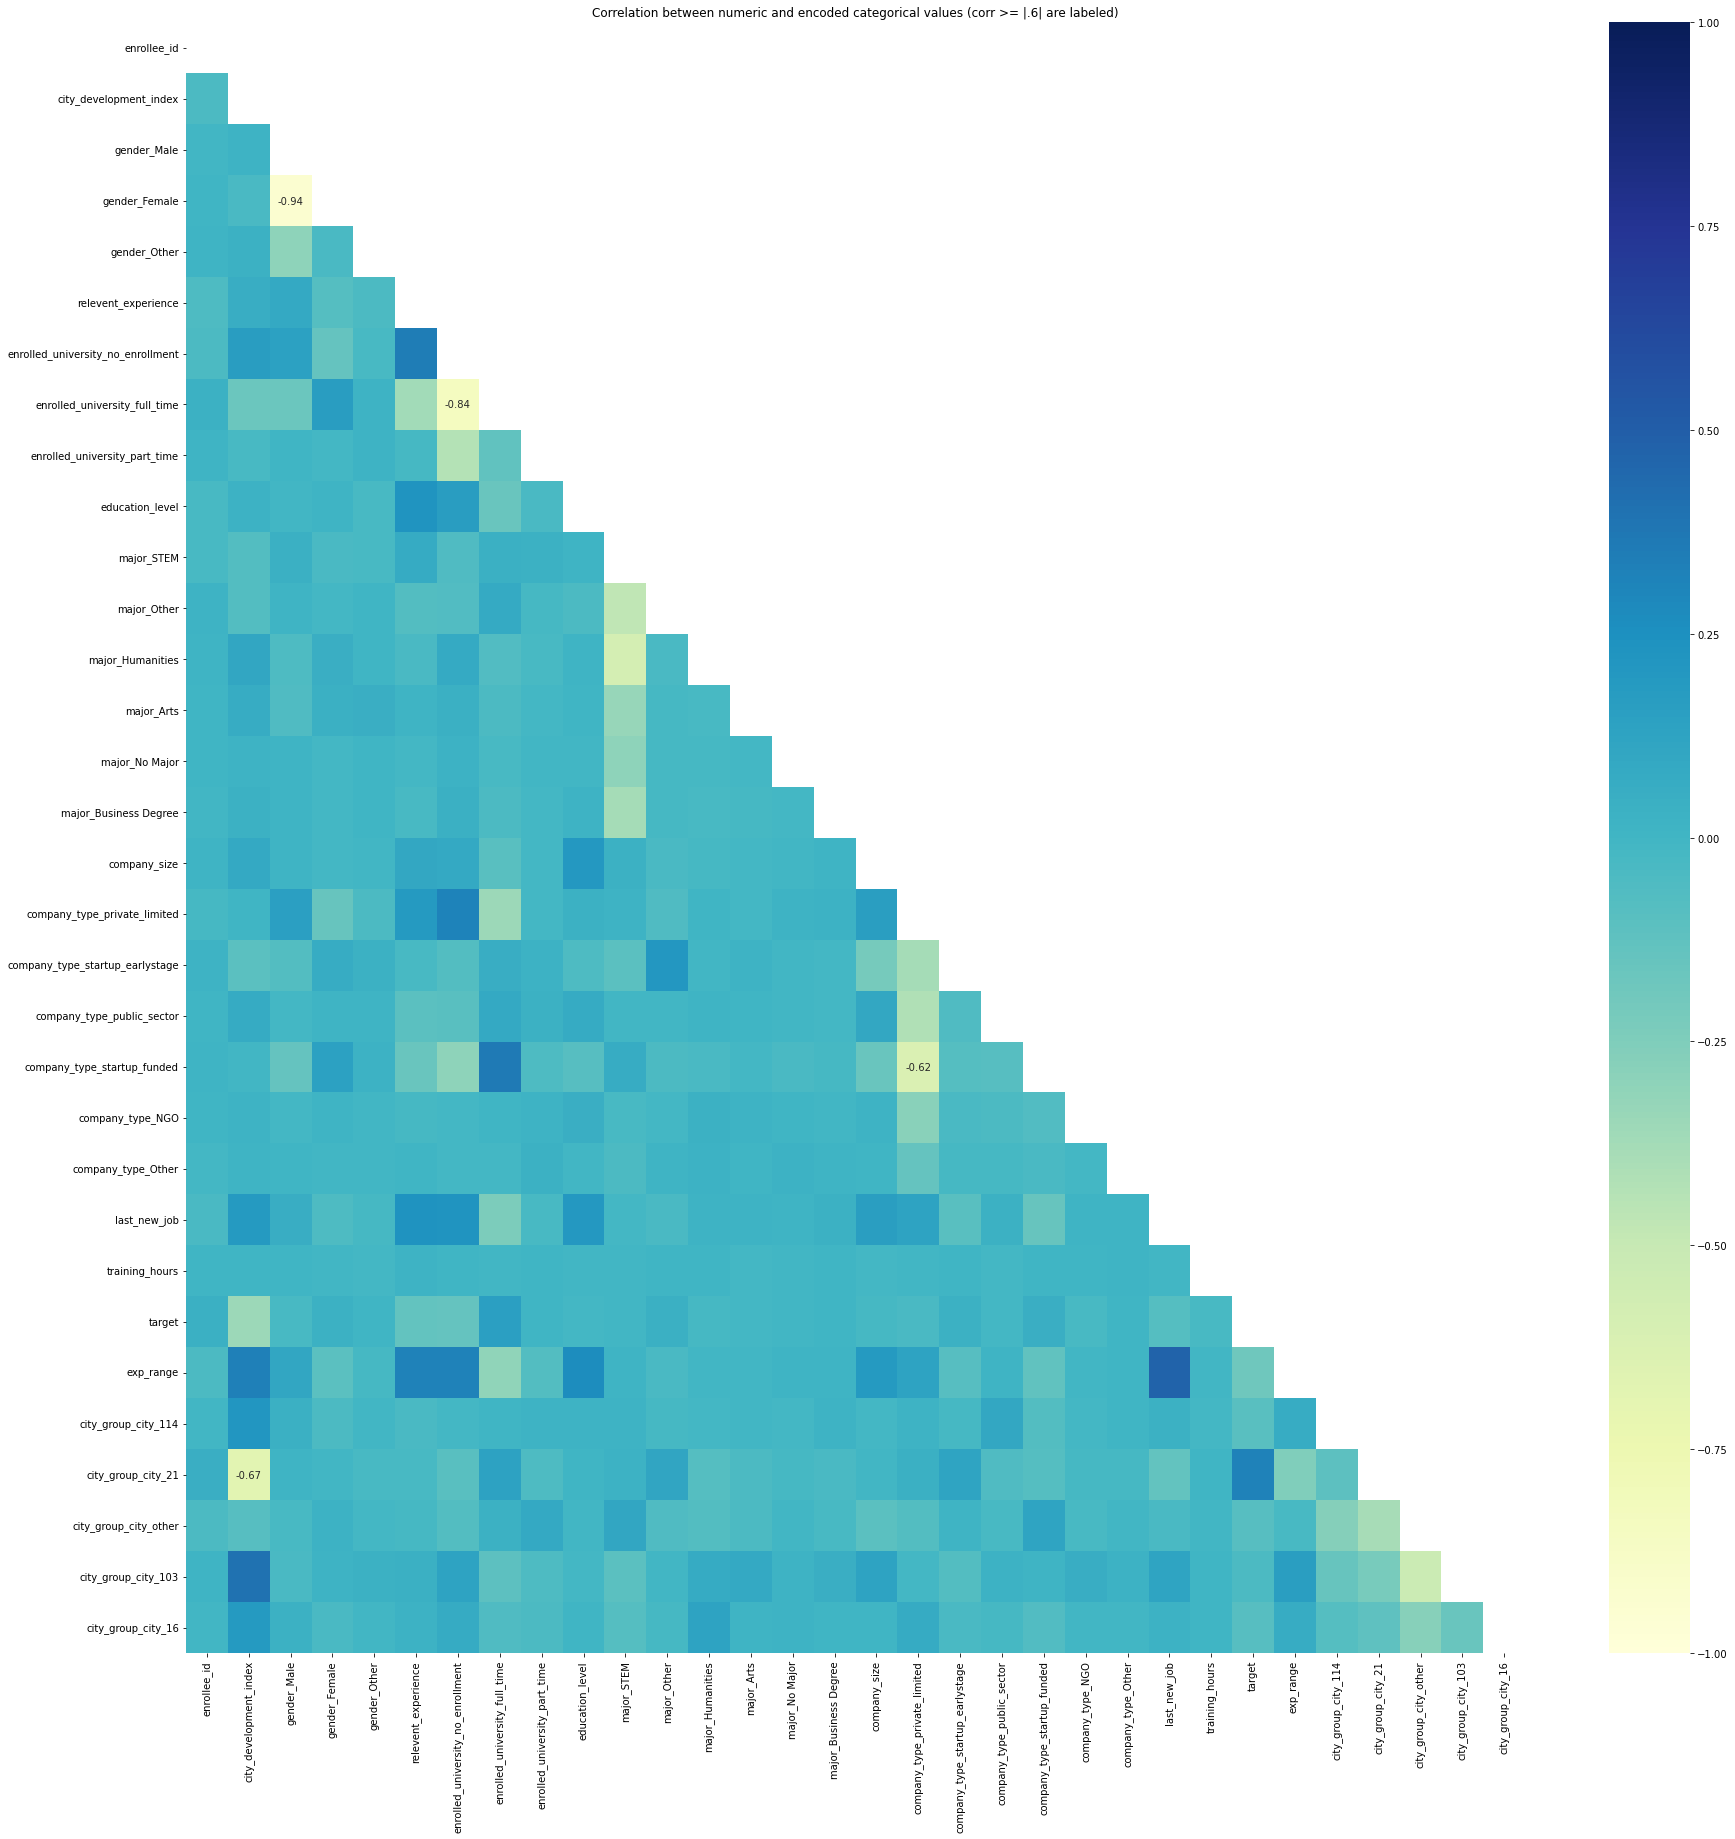

In [42]:
# Mask to only annotate correlations greater than abs .6
mask = (train.corr()>=.6) | (train.corr()<=-.6)
annotations = np.array(round(train.corr(), 2)[mask].astype(str))
annotations[np.isnan(train.corr()[mask])] = ""

matrix = np.triu(train.corr())

# Plot
plt.figure(figsize=(30,30))
x = sns.heatmap(train.corr(), annot=annotations, cmap='YlGnBu', vmin=-1, vmax=1, fmt='', mask=matrix);
x.set_title('Correlation between numeric and encoded categorical values (corr >= |.6| are labeled)');

There seems to be some multicollinearity between one-hot encoded columns. For correlation coefficients above |.60|, one column will be dropped.

These are:
- gender_female * gender_male
- enrolled_full_time * no_enrollment
- major_other * major_STEM

In [43]:
train.drop(columns=['gender_Male', 'enrolled_university_no_enrollment', 'major_STEM'], inplace=True)
test.drop(columns=['gender_Male', 'enrolled_university_no_enrollment', 'major_STEM'], inplace=True)
final_eval_df.drop(columns=['gender_Male', 'enrolled_university_no_enrollment', 'major_STEM'], inplace=True)

# IV. Save Train, Test, and Final Eval Data

In [44]:
train.shape, test.shape

((14181, 29), (4727, 29))

In [45]:
train.to_csv('../data/Train.csv')
test.to_csv('../data/Test.csv')

In [46]:
final_eval_df.shape

(2129, 29)

In [47]:
final_eval_df.to_csv('../data/Final_Eval.csv')